In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# 开始

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
import scikitplot as skplt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression 

# 导入数据

In [3]:
bank_detail_train = pd.read_table('./bank_detail_train.txt'
                                  ,sep=','
                                  ,header=None
                                  ,names=['user_id'
                                          ,'tran_time_stamp'
                                          ,'tran_type'
                                          ,'tran_amount'
                                          ,'salary_label'
                                         ]
                                 )
user_info_train = pd.read_table('./user_info_train.txt'
                                ,sep=','
                                ,header=None
                                ,names=['user_id'
                                        ,'gender'
                                        ,'occupation'
                                        ,'education'
                                        ,'married'
                                        ,'hukou'
                                       ]
                               )
bill_detail_train = pd.read_table('./bill_detail_train.txt'
                                  ,sep=','
                                  ,header=None
                                  ,names=['user_id'
                                          ,'bill_time_stamp'
                                          ,'bank_id'
                                          ,'previous_bill_amount'
                                          ,'previous_repay_amount'
                                          ,'credit_amount'
                                          ,'current_bill_balance'
                                          ,'current_bill_lowest_repay_amount'
                                          ,'frequency_consumption'
                                          ,'current_bill_amount'
                                          ,'adjust_amount'
                                          ,'cycle_interst'
                                          ,'available_balance'
                                          ,'cash_advance_limit'
                                          ,'repay_status'
                                         ]
                                )
browse_history_train = pd.read_table('./browse_history_train.txt'
                                    ,sep=','
                                    ,header=None
                                    ,names=['user_id'
                                            ,'browse_time_stamp'
                                            ,'browse_behavior'
                                            ,'browse_sub_behavior_num'
                                           ]
                                    )
loan_time_train = pd.read_table('./loan_time_train.txt'
                               ,sep=','
                               ,header=None
                               ,names=['user_id', 'loan_time']
                               )
overdue_train = pd.read_table('./overdue_train.txt'
                             ,sep=','
                             ,header=None
                             ,names=['user_id', 'overdue_label']
                             )

In [4]:
bank_1 = bank_detail_train.copy()
bill_1 = bill_detail_train.copy()
user_1 = user_info_train.copy()
browse_1 = browse_history_train.copy()
loan_1 = loan_time_train.copy()
overdue_1 = overdue_train.copy()

# 初步探索

## 缺失值

In [18]:
# 总体数据缺失否
bank_1.isnull().mean()

user_id            0.0
tran_time_stamp    0.0
tran_type          0.0
tran_amount        0.0
salary_label       0.0
dtype: float64

In [19]:
# 交易时间戳为0表示未知,查看比率
bank_1[bank_1['tran_time_stamp'] == 0].shape[0] / bank_1.shape[0]

0.006387436849248879

## 删除时间戳为0的记录

In [5]:
ind = bank_1[bank_1['tran_time_stamp'] == 0].index
bank_1.drop(labels=ind, axis=0, inplace=True)

## 删除重复记录

In [21]:
print('银行流水是有重复记录:', any(bank_1.duplicated()))

银行流水是有重复记录: True


In [22]:
print('原数据记录条数:', bank_1.shape[0])

# 重复记录数
print('重复记录条数:', bank_1[bank_1.duplicated()].shape[0])

原数据记录条数: 6031424
重复记录条数: 796944


In [24]:
bank_1.drop_duplicates(inplace=True)
# 删除
print('删除后记录条数:', bank_1.shape[0])

删除后记录条数: 5234480


In [25]:
# 其他表作同样操作
# bill_1  
# user_1  
# browse_1   
# loan_1 
# overdue_1  

any(bill_1.duplicated())
any(user_1.duplicated())
any(browse_1.duplicated())
any(loan_1.duplicated())
any(overdue_1.duplicated())

True

False

True

False

False

In [6]:
bill_1.drop_duplicates(inplace=True)
browse_1.drop_duplicates(inplace=True)

In [7]:
# bill的时间戳为0占比为20%，不做删除处理
bill_1[bill_1['bill_time_stamp'] == 0].shape[0] / bill_1.shape[0]

0.1960538376187949

## 各表用户数

In [28]:
# 银行流水用户的数据最齐全

print('用户表的用户数：', user_1['user_id'].nunique()
     ,'银行流水表的用户数：', bank_1['user_id'].nunique()
     ,'账单表的用户数：', bill_1['user_id'].nunique()
     ,'浏览表用户数：', browse_1['user_id'].nunique()
     ,'放款表用户数：', loan_1['user_id'].nunique()
     ,'逾期表用户数：', overdue_1['user_id'].nunique())

用户表的用户数： 55596 银行流水表的用户数： 9294 账单表的用户数： 53174 浏览表用户数： 47330 放款表用户数： 55596 逾期表用户数： 55596


# 数据清洗

In [7]:
# 利用放款时间表对用户做一个筛选
bank_2 = pd.merge(bank_1, loan_1, how='inner', on='user_id')
bank_2.columns
bank_2.shape

Index(['user_id', 'tran_time_stamp', 'tran_type', 'tran_amount',
       'salary_label', 'loan_time'],
      dtype='object')

(6031424, 6)

In [8]:
bank_2 = bank_2[bank_2['tran_time_stamp'] < bank_2['loan_time']]
bank_2.shape

(5632004, 6)

In [9]:
# 其它表做同样的操作
bill_2 = pd.merge(bill_1, loan_1, how='inner', on='user_id')
bill_2 = bill_2[bill_2['bill_time_stamp'] < bill_2['loan_time']]

browse_2 = pd.merge(browse_1, loan_1, how='inner', on='user_id')
browse_2 = browse_2[browse_2['browse_time_stamp'] < browse_2['loan_time']]

user_2 = user_1.copy()
overdue_2 = overdue_1.copy()

In [35]:
bank_2['user_id'].nunique()

9268

## 银行流水

In [10]:
# 银行流水用户id
bank_user = bank_2[['user_id']]
bank_user = bank_user.drop_duplicates(subset='user_id', keep='first')
bank_user.shape

(9268, 1)

In [38]:
bank_2.head()

,user_id,tran_time_stamp,tran_type,tran_amount,salary_label,loan_time
0,6965,5894316387,0,13.756664,0,5923841487
1,6965,5894321388,1,13.756664,0,5923841487
2,6965,5897553564,0,14.449810,0,5923841487
3,6965,5897563463,1,10.527763,0,5923841487
4,6965,5897564598,1,13.651303,0,5923841487


### 银行特征创建

In [11]:
# 收入
gb1 = bank_2[bank_2['tran_type'] == 0].groupby(['user_id'], as_index=False)
income = gb1['tran_amount'].agg({'income_sum': 'sum', 'income_cnt': 'count'})
income['income_avg'] = income['income_sum'] / income['income_cnt']
income.head()

,user_id,income_sum,income_cnt,income_avg
0,1,480.692762,35,13.734079
1,3,1715.933526,139,12.344846
2,4,928.506655,82,11.323252
3,9,152.871054,11,13.897369
4,10,890.532428,70,12.721892


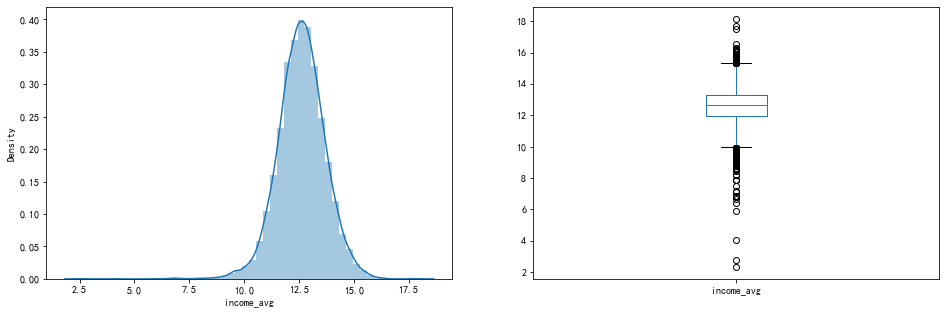

In [12]:
# 均收入的分布情况
plt.figure()
plt.subplot(121)
sns.distplot(income['income_avg']);
plt.subplot(122)
income['income_avg'].plot.box(figsize=(16,5))
plt.show();

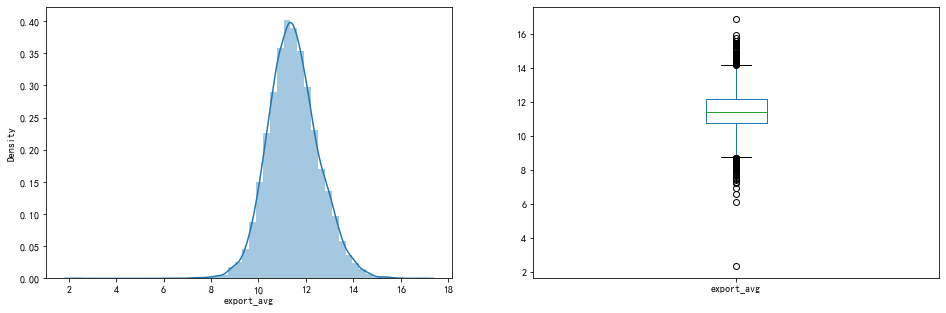

In [13]:
# 支出
gb2 = bank_2[bank_2['tran_type'] == 1].groupby(['user_id'], as_index=False)
export = gb2['tran_amount'].agg({'export_sum': 'sum', 'export_cnt': 'count'})
export['export_avg'] = export['export_sum'] / export['export_cnt']

# 均收入的分布情况
plt.figure()
plt.subplot(121)
sns.distplot(export['export_avg']);
plt.subplot(122)
export['export_avg'].plot.box(figsize=(16,5))
plt.show();

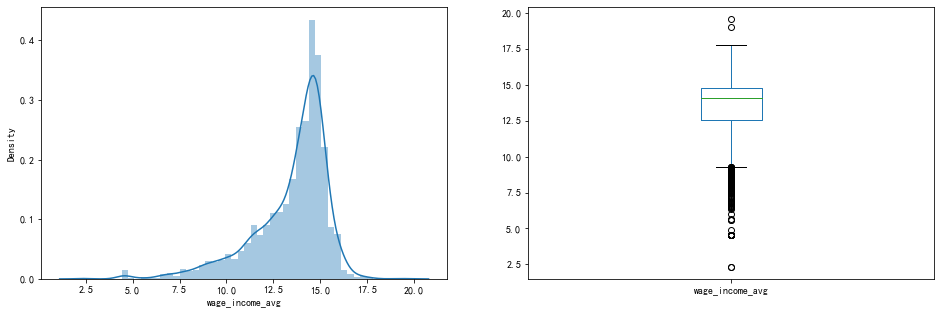

In [14]:
# 工资收入
gb3 = bank_2[bank_2['salary_label'] == 1].groupby(['user_id'], as_index=False)
wage = gb3['tran_amount'].agg({'wage_income_sum': 'sum', 'wage_income_cnt': 'count'})
wage['wage_income_avg'] = wage['wage_income_sum'] / wage['wage_income_cnt']

# 工资收入的分布情况
plt.figure()
plt.subplot(121)
sns.distplot(wage['wage_income_avg']);
plt.subplot(122)
wage['wage_income_avg'].plot.box(figsize=(16,5))
plt.show();

In [58]:

xbar = wage.wage_income_avg.mean()
xstd = wage.wage_income_avg.std()
t = xbar - 3 * xstd
t
wage[wage['wage_income_avg'] < t].shape

# 44个id，可以不做处理

7.374849390401766

(44, 4)

In [15]:
# 

bank_3 = pd.merge(bank_user, income, how='left', on='user_id')
bank_3 = pd.merge(bank_3, export, how='left', on='user_id')
bank_3 = pd.merge(bank_3, wage, how='left', on='user_id')
bank_3.fillna(0, inplace=True)
bank_3.head()

,user_id,income_sum,income_cnt,income_avg,export_sum,export_cnt,export_avg,wage_income_sum,wage_income_cnt,wage_income_avg
0,6965,972.850228,75.0,12.971336,3222.384745,288.0,11.188836,0.000000,0.0,0.000000
1,1265,1695.142678,124.0,13.670505,3610.695042,290.0,12.450673,0.000000,0.0,0.000000
2,2583,2736.475318,213.0,12.847302,7064.310678,618.0,11.430923,0.000000,0.0,0.000000
3,29165,2250.094479,187.0,12.032591,5063.039288,470.0,10.772424,202.630532,14.0,14.473609
4,2443,3020.288782,252.0,11.985273,3762.790364,341.0,11.034576,0.000000,0.0,0.000000


In [16]:
bank_3.shape
bank_4 = bank_3.loc[:, ['user_id', 'income_avg', 'export_avg', 'wage_income_avg']]
bank_4.head()

(9268, 10)

,user_id,income_avg,export_avg,wage_income_avg
0,6965,12.971336,11.188836,0.000000
1,1265,13.670505,12.450673,0.000000
2,2583,12.847302,11.430923,0.000000
3,29165,12.032591,10.772424,14.473609
4,2443,11.985273,11.034576,0.000000


In [16]:
bank_4.shape

(9268, 4)

### 相关性

(<Figure size 432x432 with 1 Axes>, <AxesSubplot:>)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<AxesSubplot:>

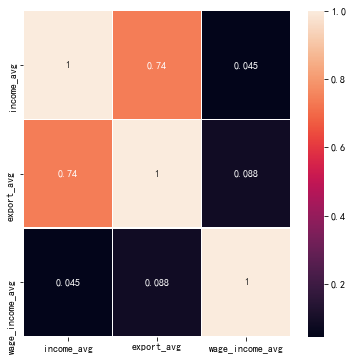

In [17]:
co = bank_4[['income_avg', 'export_avg', 'wage_income_avg']].corr()
plt.subplots(figsize=(6, 6))
plt.xticks(rotation='0')
sns.heatmap(co, square=False, linewidths=0.5, annot=True)

In [ ]:
# 收入笔均和支出有强相关性！

## 浏览表

In [18]:
browse_user = browse_2[['user_id']]
browse_user.shape
browse_user.drop_duplicates(inplace=True)
browse_user.shape

(2337478, 1)

(44945, 1)

In [67]:
browse_2.head()

,user_id,browse_time_stamp,browse_behavior,browse_sub_behavior_num,loan_time
0,34801,5926003545,173,1,5929543887
1,34801,5926003545,164,4,5929543887
2,34801,5926003545,38,7,5929543887
3,34801,5926003545,45,1,5929543887
4,34801,5926003545,110,7,5929543887


In [19]:
gb = browse_2.groupby(['user_id'], as_index=False)
browse_beh = gb['browse_behavior'].agg({'browse_beh_cnt': 'count'})
browse_beh.head()

,user_id,browse_beh_cnt
0,2,87
1,3,55
2,4,47
3,6,3
4,7,72


### 特征创造

In [20]:
browse_3 = pd.merge(browse_user, browse_beh, how='left', on='user_id')
browse_3.head()

,user_id,browse_beh_cnt
0,34801,52
1,24129,32
2,40533,6
3,32384,100
4,44309,17


### 数据表现

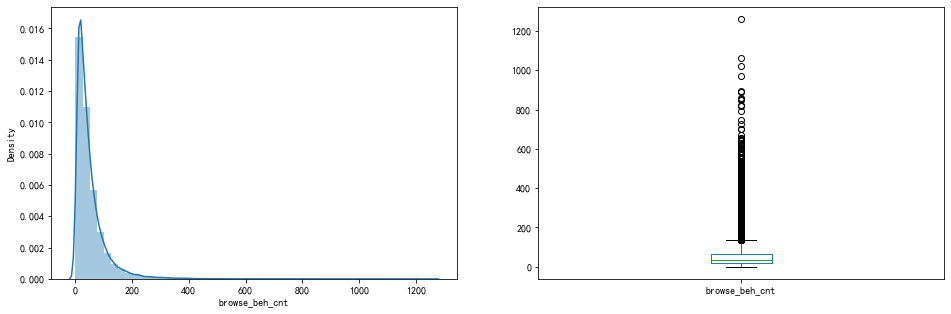

In [23]:
#  分布情况
plt.figure()
plt.subplot(121)
sns.distplot(browse_3['browse_beh_cnt']);
plt.subplot(122)
browse_3['browse_beh_cnt'].plot.box(figsize=(16,5))
plt.show();

### 异常处理

In [21]:
# 出现偏态，对数化
browse_4 = browse_3.copy()

browse_4['browse_beh_cnt_log'] = np.log(browse_4['browse_beh_cnt'])

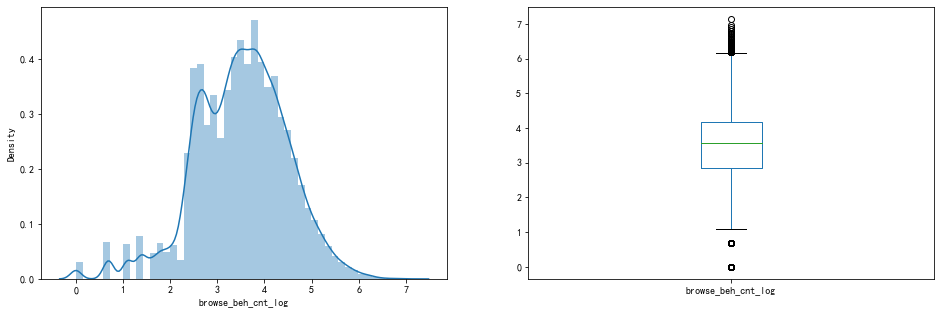

In [23]:
plt.figure()
plt.subplot(121)
sns.distplot(browse_4['browse_beh_cnt_log']);
plt.subplot(122)
browse_4['browse_beh_cnt_log'].plot.box(figsize=(16,5))
plt.show();

In [49]:
browse_4.head()

,user_id,browse_beh_cnt,browse_beh_cnt_log
0,34801,52,3.951244
1,24129,32,3.465736
2,40533,6,1.791759
3,32384,100,4.605170
4,44309,17,2.833213


## 账单表

In [51]:
bill_2.columns
bill_2.head()

Index(['user_id', 'bill_time_stamp', 'bank_id', 'previous_bill_amount',
       'previous_repay_amount', 'credit_amount', 'current_bill_balance',
       'current_bill_lowest_repay_amount', 'frequency_consumption',
       'current_bill_amount', 'adjust_amount', 'cycle_interst',
       'available_balance', 'cash_advance_limit', 'repay_status', 'loan_time'],
      dtype='object')

,user_id,bill_time_stamp,bank_id,previous_bill_amount,previous_repay_amount,credit_amount,current_bill_balance,current_bill_lowest_repay_amount,frequency_consumption,current_bill_amount,adjust_amount,cycle_interst,available_balance,cash_advance_limit,repay_status,loan_time
0,3150,5906744363,6,18.626118,18.661937,20.664418,18.905766,17.847133,1,0.0,0.0,0.0,0.0,19.971271,0,5919867087
1,3150,5906744401,6,18.905766,18.909954,20.664418,19.113305,17.911506,1,0.0,0.0,0.0,0.0,19.971271,0,5919867087
2,3150,5906744427,6,19.113305,19.150290,20.664418,19.300194,17.977610,1,0.0,0.0,0.0,0.0,19.971271,0,5919867087
3,3150,5906744515,6,19.300194,19.300280,21.000890,20.303240,18.477177,1,0.0,0.0,0.0,0.0,20.307743,0,5919867087
4,3150,5906744562,6,20.303240,20.307744,21.000890,20.357134,18.510985,1,0.0,0.0,0.0,0.0,20.307743,0,5919867087


### 特征创造

In [22]:
bill_bank = bill_2[['user_id', 'bank_id']]
bill_bank.drop_duplicates(inplace=True)

# 银行卡张数
gb = bill_bank.groupby(['user_id'], as_index=False)
bank_cnt = gb['bank_id'].agg({'bank_cnt': 'count'})
bank_cnt.head()

,user_id,bank_cnt
0,2,3
1,3,1
2,4,3
3,5,1
4,6,3


In [23]:
bill_3 = bill_2.copy()

# 衍生其他变量
bill_3['previous_bill_amt_nonrepay'] = bill_3['previous_bill_amount'] - bill_3['previous_repay_amount']
bill_3['adjacent_bill_amt_diff'] = bill_3['current_bill_amount'] - bill_3['previous_bill_amount']
bill_3['current_repay_amt_sum'] = bill_3['previous_bill_amount'] - bill_3['previous_repay_amount'] + bill_3['current_bill_amount'] - bill_3['adjust_amount'] + bill_3['cycle_interst']
bill_3['used_credit_amt'] = bill_3['credit_amount'] - bill_3['available_balance']
bill_3.columns

Index(['user_id', 'bill_time_stamp', 'bank_id', 'previous_bill_amount',
       'previous_repay_amount', 'credit_amount', 'current_bill_balance',
       'current_bill_lowest_repay_amount', 'frequency_consumption',
       'current_bill_amount', 'adjust_amount', 'cycle_interst',
       'available_balance', 'cash_advance_limit', 'repay_status', 'loan_time',
       'previous_bill_amt_nonrepay', 'adjacent_bill_amt_diff',
       'current_repay_amt_sum', 'used_credit_amt'],
      dtype='object')

In [24]:
bill_4 = bill_3.drop(['bill_time_stamp', 'bank_id', 'repay_status', 'loan_time'], axis=1)
gb = bill_4.groupby(['user_id'], as_index=False)
bill_5 = gb['previous_bill_amount',
       'previous_repay_amount', 'credit_amount', 'current_bill_balance',
       'current_bill_lowest_repay_amount', 'frequency_consumption',
       'current_bill_amount', 'adjust_amount', 'cycle_interst',
       'available_balance', 'cash_advance_limit',
       'previous_bill_amt_nonrepay', 'adjacent_bill_amt_diff',
       'current_repay_amt_sum', 'used_credit_amt'].agg(np.mean)
bill_5.head()

,user_id,previous_bill_amount,previous_repay_amount,credit_amount,current_bill_balance,current_bill_lowest_repay_amount,frequency_consumption,current_bill_amount,adjust_amount,cycle_interst,available_balance,cash_advance_limit,previous_bill_amt_nonrepay,adjacent_bill_amt_diff,current_repay_amt_sum,used_credit_amt
0,2,15.415042,15.279627,15.882547,19.346253,10.369608,2.500000,15.272842,0.0,0.0,0.000000,2.037674,0.135415,-0.142200,15.408256,15.882547
1,3,18.366771,18.580174,18.361833,18.348270,16.045651,2.000000,18.581412,0.0,0.0,0.000000,0.000000,-0.213403,0.214641,18.368008,18.361833
2,4,7.240665,5.257402,16.921144,18.637185,17.340947,0.100000,7.938334,0.0,0.0,1.825816,8.425011,1.983262,0.697669,9.921596,15.095328
3,5,20.679226,18.539760,20.664418,20.636046,18.474369,0.000000,17.957256,0.0,0.0,0.000000,19.971271,2.139466,-2.721970,20.096722,20.664418
4,6,19.134415,17.363353,20.567794,19.176074,17.976737,2.904762,12.452313,0.0,0.0,2.447743,13.788434,1.771062,-6.682102,14.223375,18.120052


In [25]:
bill_5 = pd.merge(bank_cnt, bill_5, how='inner', on='user_id')

In [59]:
bill_5.shape

(46558, 17)

### 相关性

In [82]:
bill_5.columns

Index(['user_id', 'bank_cnt', 'previous_bill_amount', 'previous_repay_amount',
       'credit_amount', 'current_bill_balance',
       'current_bill_lowest_repay_amount', 'frequency_consumption',
       'current_bill_amount', 'adjust_amount', 'cycle_interst',
       'available_balance', 'cash_advance_limit', 'previous_bill_amt_nonrepay',
       'adjacent_bill_amt_diff', 'current_repay_amt_sum', 'used_credit_amt'],
      dtype='object')

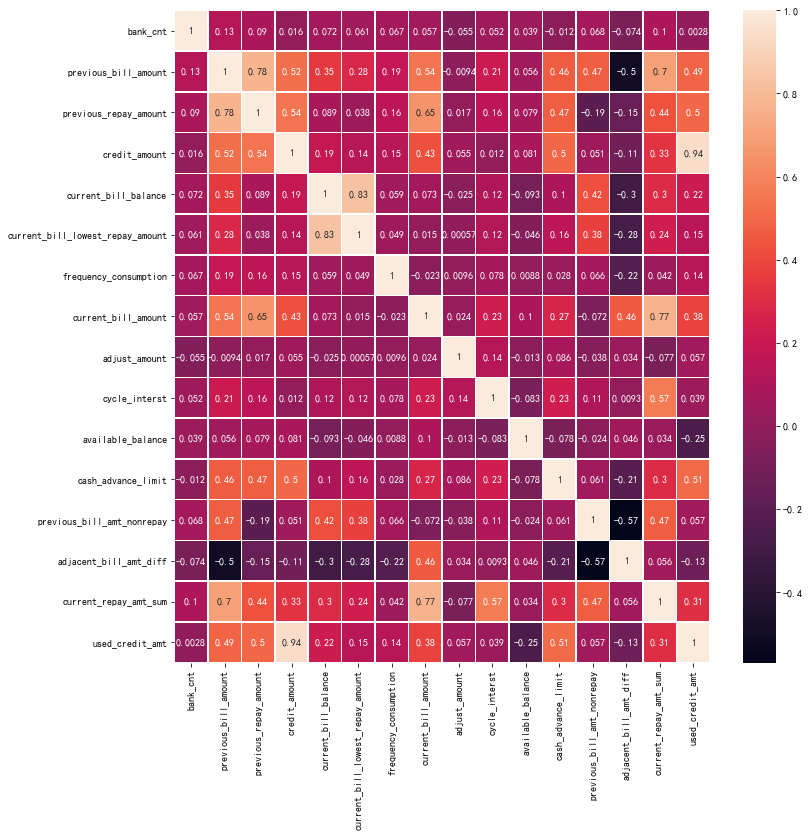

In [28]:
cols = ['bank_cnt', 'previous_bill_amount', 'previous_repay_amount',
       'credit_amount', 'current_bill_balance',
       'current_bill_lowest_repay_amount', 'frequency_consumption',
       'current_bill_amount', 'adjust_amount', 'cycle_interst',
       'available_balance', 'cash_advance_limit', 'previous_bill_amt_nonrepay',
       'adjacent_bill_amt_diff', 'current_repay_amt_sum', 'used_credit_amt']

cor = bill_5[cols].corr()
plt.subplots(figsize=(12, 12))
plt.xticks(rotation='0')
sns.heatmap(cor, square=False, linewidths=0.5, annot=True)
plt.show();

In [ ]:
# 去掉 'previous_bill_amount', 'current_bill_balance', 'current_bill_amount', 'used_credit_amt'

# 合并各表

In [26]:
df_1 = pd.merge(bank_4, browse_4, how='inner', on='user_id')
df_1 = pd.merge(df_1, bill_5, how='inner', on='user_id')
df_1.shape

(5730, 22)

In [27]:
# 银行、账单、浏览记录合并后有5730个用户信息
# 合并用户信息和违约，构建完整数据集合
df_2 = pd.merge(user_2, df_1, how='inner', on='user_id')
df_2 = pd.merge(df_2, overdue_2, how='inner', on='user_id')
df_2.shape

(5730, 28)

In [64]:
# 数据存在轻微不平衡
df_2['overdue_label'].value_counts()

0    4895
1     835
Name: overdue_label, dtype: int64

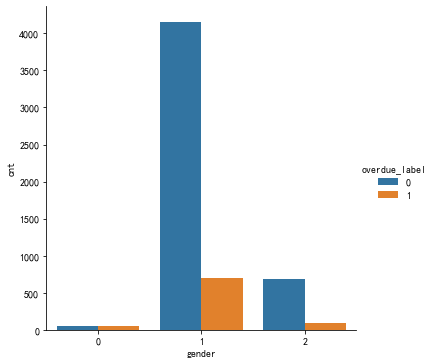

In [79]:
# 性别和违约的分类统计

# gb = df_2.groupby(['gender'], as_index=False)
# g = gb['gender'].agg({'gender_sum': 'count'})


# gb = df_2.groupby(['gender', 'overdue_label'], as_index=False)
# gg = gb['user_id'].count()
# gg.rename(columns={'user_id': 'cnt'}, inplace=True)

# gender = pd.merge(gg, g, how='inner', on='gender')

# sns.catplot(x="gender", y='cnt', hue="overdue_label", data=gender, kind='bar')

<AxesSubplot:xlabel='education'>

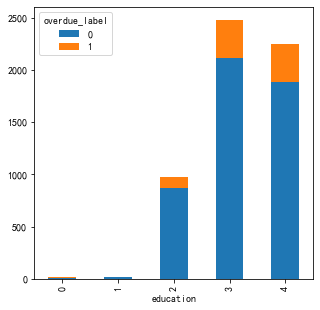

In [92]:
# education=pd.crosstab(df_2['education'], df_2['overdue_label'])
# education.plot(kind="bar", stacked=True, figsize=(5,5))

# 变量选择

In [84]:
df_2.shape
df_2.columns

(5730, 28)

Index(['user_id', 'gender', 'occupation', 'education', 'married', 'hukou',
       'income_avg', 'export_avg', 'wage_income_avg', 'browse_beh_cnt',
       'browse_beh_cnt_log', 'bank_cnt', 'previous_bill_amount',
       'previous_repay_amount', 'credit_amount', 'current_bill_balance',
       'current_bill_lowest_repay_amount', 'frequency_consumption',
       'current_bill_amount', 'adjust_amount', 'cycle_interst',
       'available_balance', 'cash_advance_limit', 'previous_bill_amt_nonrepay',
       'adjacent_bill_amt_diff', 'current_repay_amt_sum', 'used_credit_amt',
       'overdue_label'],
      dtype='object')

In [88]:
import toad
toad.quality(df_2.iloc[:, 1:-1], df_2['overdue_label'], iv_only=True)

,iv,gini,entropy,unique
income_avg,0.203163,NaN,NaN,5727.0
previous_bill_amt_nonrepay,0.162342,NaN,NaN,5238.0
export_avg,0.152651,NaN,NaN,5725.0
gender,0.108776,NaN,NaN,3.0
wage_income_avg,0.107337,NaN,NaN,1737.0
cash_advance_limit,0.091024,NaN,NaN,3627.0
current_repay_amt_sum,0.078218,NaN,NaN,5307.0
current_bill_lowest_repay_amount,0.074105,NaN,NaN,5630.0
previous_repay_amount,0.073577,NaN,NaN,5207.0
frequency_consumption,0.071014,NaN,NaN,2023.0


In [29]:
# 去掉  'export_avg', 'previous_bill_amount', 'current_bill_balance', 'current_bill_amount', 'used_credit_amt',
# 'available_balance', 'adjust_amount'
# 对于分类变量，去掉 'hukou', 'education', 'married'

df_3 = df_2.drop(['export_avg', 'previous_bill_amount', 'current_bill_balance', 'current_bill_amount', 'used_credit_amt'
                 ,'hukou', 'education', 'married', 'available_balance', 'adjust_amount'], axis=1)
df_3.columns

Index(['user_id', 'gender', 'occupation', 'income_avg', 'wage_income_avg',
       'browse_beh_cnt', 'browse_beh_cnt_log', 'bank_cnt',
       'previous_repay_amount', 'credit_amount',
       'current_bill_lowest_repay_amount', 'frequency_consumption',
       'cycle_interst', 'cash_advance_limit', 'previous_bill_amt_nonrepay',
       'adjacent_bill_amt_diff', 'current_repay_amt_sum', 'overdue_label'],
      dtype='object')

In [138]:
df_3.shape

(5730, 18)

# 建模

## 数据集分割

In [30]:
X = df_3.drop(['user_id', 'overdue_label'], axis=1)
X = np.array(X)

Y = df_3[['overdue_label']]
Y = np.array(Y)

X.shape
Y.shape

from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.3)

(5730, 16)

(5730, 1)

## 决策树

In [32]:
from time import time
import datetime

time0 = time()
parameters_clf = {
    'criterion': ('gini', 'entropy')
    ,'splitter': ('best', 'random')
    ,'max_depth': [*range(1, 10)]
#    ,'min_samples_leaf': [*range(1, 50, 5)]
#    ,'min_impurity_decrease': [*np.linspace(0, 0.5, 50)]
}

clf = DecisionTreeClassifier(random_state=10)
gs_clf = GridSearchCV(clf, parameters_clf, cv=10)
gs_clf = gs_clf.fit(xtrain, ytrain)

# 返回参数组合
gs_clf.best_params_
# 评分
gs_clf.best_score_
print('运行时间：%s' % datetime.datetime.fromtimestamp(time() - time0).strftime('%M:%S:%f'))

{'criterion': 'entropy', 'max_depth': 3, 'splitter': 'best'}

0.856893835064081

运行时间：00:05:264678


In [33]:
clf_ = DecisionTreeClassifier(random_state=10
                             ,criterion='gini'
                             ,max_depth=4
                             ,splitter='random'
#                              ,min_samples_leaf=21
                             )
clf_ = clf_.fit(xtrain, ytrain)
ypred_clf = clf_.predict(xtest)
# print(classification_report(ytest, ypred_clf))
accuracy_score(ytest, ypred_clf)

0.8580570098894706

## 随机森林

In [34]:
from time import time
import datetime

time0 = time()

parameters_rfc = {
    'max_features': range(3, 11, 1)
}

rfc = RandomForestClassifier(random_state=10
                            ,min_samples_leaf=10
                             ,max_depth=11
#                             ,max_features=10
                             ,n_estimators=20
                             ,min_samples_split=100
                             ,oob_score=True
                            )
gs_rfc = GridSearchCV(rfc, parameters_rfc, cv=10)
gs_rfc = gs_rfc.fit(xtrain, ytrain)

# 返回参数组合
gs_rfc.best_params_
# 评分
gs_rfc.best_score_


print('运行时间：%s' % datetime.datetime.fromtimestamp(time() - time0).strftime('%M:%S:%f'))

{'max_features': 10}

0.8563950819468742

运行时间：00:17:209559


In [35]:

time0 = time()

rfc = RandomForestClassifier(random_state=10
                             ,min_samples_leaf=10
                             ,max_depth=11
                             ,max_features=10
                             ,n_estimators=20
                             ,min_samples_split=100
                             ,oob_score=True
                            )
rfc_ = rfc.fit(xtrain, ytrain)
ypred_rfc = rfc_.predict(xtest)
# print(classification_report(ytest, ypred_rfc))
accuracy_score(ytest, ypred_rfc)

print('运行时间：%s' % datetime.datetime.fromtimestamp(time() - time0).strftime('%M:%S:%f'))


0.8551483420593369

运行时间：00:00:343743


## 支持向量机

In [ ]:
times = time() 

for kernel in ["linear","poly","rbf","sigmoid"]:
    svc_ = SVC(kernel=kernel
              ,gamma="auto"
              ,degree=1
              ,cache_size=5000
             ).fit(xtrain, ytrain)
    result = svc_.predict(xtest)
    score = svc_.score(xtest, ytest)
    recall = recall_score(ytest, result)
    auc = roc_auc_score(ytest, svc_.decision_function(xtest))
    print("%s 's testing accuracy %f, recall is %f', auc is %f" % (kernel, score, recall, auc))
    print(datetime.datetime.fromtimestamp(time()-times).strftime("%M:%S:%f"))

## 逻辑回归

In [52]:
from time import time
import datetime

time0 = time()
parameters_lr = {
    'penalty': ['l1', 'l2']
    ,'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

lr_ = LogisticRegression(random_state=10
                        )
gs_lr = GridSearchCV(lr_, parameters_lr, cv=10)
gs_lr = gs_lr.fit(xtrain, ytrain)

# 返回参数组合
gs_lr.best_params_
# 评分
gs_lr.best_score_
print('运行时间：%s' % datetime.datetime.fromtimestamp(time() - time0).strftime('%M:%S:%f'))

{'C': 0.01, 'penalty': 'l2'}

0.8534031835833302

运行时间：00:04:285456


In [53]:
lr = LogisticRegression(random_state=10
                        ,penalty='l2'
                        ,C=0.01
                       )
lr = lr.fit(xtrain, ytrain)
ypred_lr = lr.predict(xtest)
# print(classification_report(ytest, ypred_rfc))
accuracy_score(ytest, ypred_lr)


0.8574752763234439